# Artificial Intelligence
## Image Generator

OpenAI Dall-E (and others) are text-to-image models developed by OpenAI using deep learning methodologies to generate digital images from natural language descriptions, called "prompts".

Reference:

+ https://gemini.google.com/app
+ https://openai.com/index/dall-e-2/
+ https://cloud.google.com/vertex-ai/generative-ai/docs/image/img-gen-prompt-guide
+ https://tech.co/news/use-google-bard-ai-image-generator

In [1]:
BUCKET_NAME       = "cio-training-vertex-colab"
PROJECT_ID        = "ai-bootcamp-oct-2024"
LOCATION          = "us-central1"
secret_name       = "ai-training-key-secret"
secret_version    = "latest"
secret_project_id = "usfs-tf-admin"
resource_name     = f"projects/{secret_project_id}/secrets/{secret_name}/versions/{secret_version}"

## Environment Check

In [2]:
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#- Google Colab Check
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
import sys
import subprocess
import importlib.util

RunningInCOLAB = False
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    print("You are running this notebook in Google Colab.")
else:
    print("You are running this notebook with Jupyter iPython runtime.")

You are running this notebook in Google Colab.


# GCP Gemini Setup

In [3]:
#Download Google Vextex/AI Libraries
subprocess.run(["pip", "install" , "--upgrade", "google-cloud-aiplatform", "--quiet"])


libraries=["google-generativeai", "google-cloud-secret-manager", "openai"]

for library in libraries:
    spec = importlib.util.find_spec(library)
    if spec is None:
      print("Installing library " + library)
      subprocess.run(["pip", "install" , library, "--quiet"])
    else:
      print("Library " + library + " already installed.")

from google.cloud import aiplatform
import vertexai.preview
from google.cloud import secretmanager
import vertexai
import openai
from google.auth import default, transport

Installing library google-generativeai
Installing library google-cloud-secret-manager
Library openai already installed.


## Libraries

In [4]:
############################################
# INCLUDES
############################################
#libraries specific to this example
## Imports
#import tensorflow as tf
#from tensorflow import keras

from IPython import display

#a set of libraries that perhaps should always be in Python source
import os
import datetime
import sys
import gc
import getopt
import inspect
import math
import warnings
import textwrap
import random
import glob
import os
import PIL
import time
import subprocess

#images
import imageio
import matplotlib as matplt
import matplotlib.pyplot as plt

#data science
import numpy as np

#a darn useful library for creating paths and one I recommend you load to your environment
from pathlib import Path

from pydoc import help                          # can type in the python console `help(name of function)` to get the documentation

warnings.filterwarnings('ignore')               # don't print out warnings

## Variables

In [5]:
############################################
# GLOBAL VARIABLES
############################################
DEBUG = 1
DEBUG_DATA = 0

# CODE CONSTRAINTS
VERSION_NAME    = "MLGENIMG"
VERSION_MAJOR   = 0
VERSION_MINOR   = 0
VERSION_RELEASE = 1

#used for values outside standard ASCII, just do it, you'll need it
ENCODING  ="utf-8"

############################################
# GLOBAL CONSTANTS
############################################
BUFFER_SIZE = 60000
BATCH_SIZE = 256
TEXT_WIDTH=77
############################################
# APPLICATION VARIABLES
############################################
start = "\033[1m"
end = "\033[0;0m"

############################################
# GLOBAL CONFIGURATION
############################################
os.environ['PYTHONIOENCODING']=ENCODING


## Function

In [6]:
## Outputs library version history of effort.
#
def lib_diagnostics() -> None:

    import pkg_resources

    package_name_length=40
    package_version_length=20

    # Get installed packages
    the_packages=["nltk", "numpy", "os", "pandas"]
    installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
    for package_idx, package_name in enumerate(installed):
         if package_name in the_packages:
             installed_version = installed[package_name]
             print(f"{package_name:<40}#: {str(pkg_resources.parse_version(installed_version)):<20}")

    try:
        print(f"{'OpenAI version':<40}#: {str(openai.__version__):<20}")
    except Exception as e:
        pass


    try:
        print(f"{'TensorFlow version':<40}#: {str(tf.__version__):<20}")
        print(f"{'     gpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('GPU')))}")
        print(f"{'     cpu.count:':<40}#: {str(len(tf.config.experimental.list_physical_devices('CPU')))}")
    except Exception as e:
        pass

    try:
        print(f"{'Torch version':<40}#: {str(torch.__version__):<20}")
        print(f"{'     GPUs available?':<40}#: {torch.cuda.is_available()}")
        print(f"{'     count':<40}#: {torch.cuda.device_count()}")
        print(f"{'     current':<40}#: {torch.cuda.current_device()}")
    except Exception as e:
        pass

    try:
      print(f"{'GCP AI Platform version':<40}#: {str(aiplatform.__version__):<20}")
    except Exception as e:
      pass

    try:
      print(f"{'GCP Vertex version':<40}#: {str(vertexai.__version__):<20}")
    except Exception as e:
      pass

    try:
      print(f"{'Secret Manager version':<40}#: {str(secretmanager.__version__):<20}")
    except Exception as e:
      pass

    return

## Function Call

In [7]:
lib_diagnostics()
wrapper = textwrap.TextWrapper(width=TEXT_WIDTH)

nltk                                    #: 3.8.1               
numpy                                   #: 1.26.4              
pandas                                  #: 2.1.4               
OpenAI version                          #: 1.51.0              
GCP AI Platform version                 #: 1.69.0              
GCP Vertex version                      #: 1.69.0              
Secret Manager version                  #: 2.20.2              


## Variables and Model Parameters



In [8]:
###########################################
#- API Parameters for things like WordCloud
#- Variables help hold information for later use
#- The "constants" represent variables that we don't anticipate changing over the course of the program.
###########################################
#model parameters
#changing the model can influence the type of response you get at the end.

#AVAILABLE MODELS - https://firebase.google.com/docs/vertex-ai/gemini-models
#Gemini 1.5 Flash	google/gemini-1.5-flash-001
#Gemini 1.5 Prov	google/gemini-1.5-pro-001
#Gemini 1.0 Prov	google/gemini-1.0-pro-002
#                   google/gemini-1.0-pro-001
#                   google/gemini-1.0-pro
# select ai model type
AI_MODEL_TYPE = "imagegeneration@006"

model_temperature=0.7                      #start at 1 and decrease for more imaginitive responses
model_max_tokens=8000                      #Gemini 1.5 ~ 1M, Gemini 1.0 ~ 16k
model_max_token_response=2048              #Gemini 1.5 ~ 8K, Gemini 1.0 ~ 2048

model_top_p=1                              #Top P specifies the cumulative probability score threshold that the tokens must reach.
                                           # For example, if you set Top P to 0.6, then only the first two tokens, for and to, are sampled
                                           # because their probabilities (0.4 and 0.25) add up to 0.65.

model_top_k=1                              #Top-k sampling samples tokens with the highest probabilities until the specified number of
                                           # tokens is reached. Top-p sampling samples tokens with the highest probability scores until
                                           # the sum of the scores reaches the specified threshold value. (Top-p sampling is also called nucleus sampling.)

summary_token_max=150



# AI Filters

In [9]:
# import the required libraries
import vertexai
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    HarmBlockThreshold,
    HarmCategory,
    Part,
    SafetySetting,
)

# safety settings

safety = [
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_HARASSMENT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_HATE_SPEECH,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
    SafetySetting(
        category = HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT,
        threshold = HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE
    ),
]

## Large Language Model (LLM) ~ Gemini Visual Model (Google)

In [10]:
# initialize vertexai
vertexai.init(project = PROJECT_ID, location = LOCATION)


In [11]:
from vertexai.preview.vision_models import ImageGenerationModel

# Create the model
# See https://ai.google.dev/api/python/google/generativeai/GenerativeModel

model = ImageGenerationModel.from_pretrained(AI_MODEL_TYPE)

## Create Your Picture Prompt

In [12]:
#options for creating an image
style=["normal", "abstract", "surrealism", "cubism", "impressionism", "3d", "expressionist painting", "manga", "pop art", "pencil sketch", "watercolor"]
detail=["normal", "realistic", "ultrarealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "photorealistic", "intricate", "highly detailed"]
position=["normal", "on the wall", "in the background", "in the foreground", "in the middle", "in the left", "in the right"]
mood=["normal", "stunning", "elegant", "radiant", "delicate", "cute", "striking" "glamorous"]
lights=["normal", "warm lighting", "natural lighting", "cold lighting", "dark aesthetic", "red tones", "blue tones"]
viewpoint=["portrait", "landscape", "close-up", "headshot", "mid-range", "3/4 shot", "full body shot", "wide shot", "low angle shot", "high angle shot"]
subject=["penguin", "bear", "tree", "dog", "cat"]
verb=["running", "surfing", "on the computer", "sleeping", "eating", "playing", "dancing", "sitting", "standing", "walking"]



#generate a picture from random choices above
picture_prompt=f"{style[random.randint(0, len(style)-1)]} \
 {detail[random.randint(0, len(detail)-1)]} \
 {position[random.randint(0, len(position)-1)]} \
 {mood[random.randint(0, len(mood)-1)]} \
 {lights[random.randint(0, len(lights)-1)]} \
 {viewpoint[random.randint(0, len(viewpoint)-1)]}\
 {subject[random.randint(0, len(subject)-1)]} \
 {verb[random.randint(0, len(verb)-1)]}"

#examples
#picture_prompt="magazine style, 4k, photorealistic, modern red armchair, natural"
picture_prompt="hyper-realistic, 4k, bear smoking a cigar surfing a shark"


#format the output to make it legible
#string = wrapper.fill(text=picture_prompt)
print(f"Random text created: {picture_prompt}")

#############################################################
# REPLACE picture_prompt with your own
# input if you want the image created to change
#############################################################


Random text created: hyper-realistic, 4k, bear smoking a cigar surfing a shark


## Execute the Image Generation

Your save location is ./output.png.
For prompt: hyper-realistic, 4k, bear smoking a cigar surfing a shark


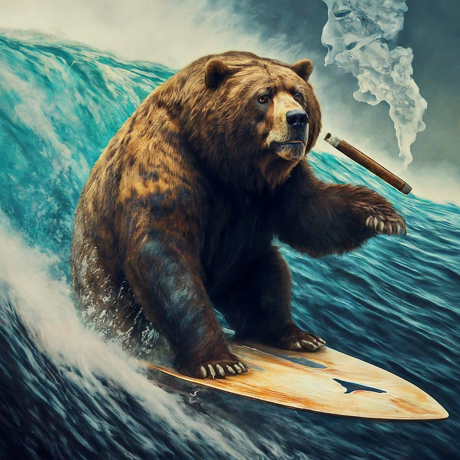

Created output image using 3660966 bytes


In [13]:
from PIL import Image
from IPython.display import display
try:
  images = model.generate_images(
      prompt=picture_prompt,

      # Optional parameters
      number_of_images=1,
      language="en",

      # You can't use a seed value and watermark at the same time.
      # add_watermark=False,
      # seed=100,
      aspect_ratio="1:1",
      safety_filter_level="block_some",
      person_generation="allow_adult",
  )

  try:
    output_file="./output.png"
    images[0].save(location=output_file, include_generation_parameters=False)
    print(f"Your save location is {output_file}.")
    print(f"For prompt: {picture_prompt}")
  except Exception as e:
    print("There was a problem saving your image.")
    print(f"{start}See exception:{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
    print(f"Your save location was {output_file}.")

  # Optional. View the generated image in a notebook.
  try:
    #images[0].show(). #without modification to size (which is huge)
    image = Image.open(output_file)
    scale = 0.3
    display(image.resize(( int(image.width * scale), int(image.height * scale))))

    print(f"Created output image using {len(images[0]._image_bytes)} bytes")
  except Exception as e:
    print("There was a problem displaying your image.")
    print(f"{start}See exception:{end} ")
    string = wrapper.fill(text=str(e))
    print(string)

except Exception as e:
  print("There was a problem creating your image.")
  print("\n")
  print(f"{start}See exception:{end} ")
  string = wrapper.fill(text=str(e))
  print(string)
  print("\n")
  print(f"{start}Your prompt was:{end} ")
  string = wrapper.fill(text=picture_prompt)
  print(string)




# Do you understand the stochastic nature of AI?

Definition of stochastic: randomly determined; having a random probability distribution or pattern that may be analyzed statistically but may not be predicted precisely.

*** If this same prompt runs multiple times, do you expect to see the same picture every time....??? ***

Image Number: 0
Your save location is ./output_0.png.
For prompt: hyper-realistic, 4k, bear smoking a cigar surfing a shark


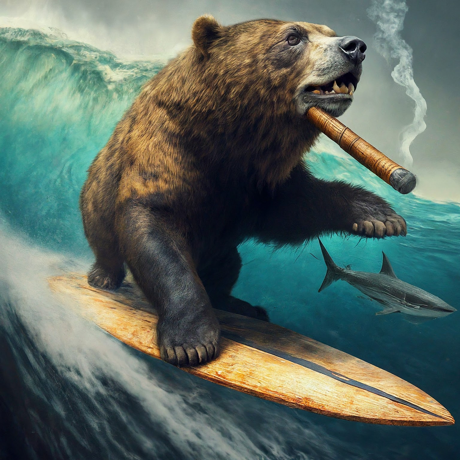

Created output image using 3719642 bytes



Image Number: 1
Your save location is ./output_1.png.
For prompt: hyper-realistic, 4k, bear smoking a cigar surfing a shark


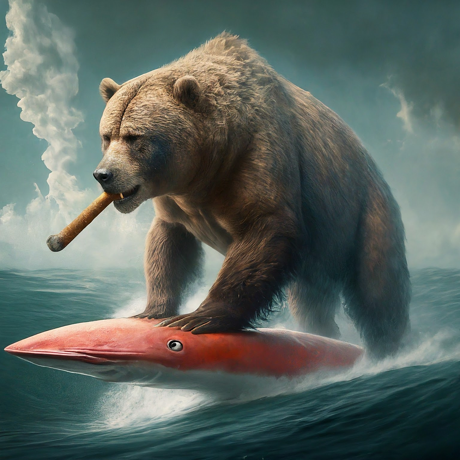

Created output image using 2848422 bytes





In [14]:
number_of_times=3
for index, value in enumerate(range(1,number_of_times)):

  try:
    images = model.generate_images(
        prompt=picture_prompt,

        # Optional parameters
        number_of_images=1,
        language="en",

        # You can't use a seed value and watermark at the same time.
        # add_watermark=False,
        # seed=100,
        aspect_ratio="1:1",
        safety_filter_level="block_some",
        person_generation="allow_adult",
    )

    try:
      output_file=f"./output_{str(index)}.png"
      images[0].save(location=output_file, include_generation_parameters=False)
      print(f"Image Number: {str(index)}")
      print(f"Your save location is {output_file}.")
      print(f"For prompt: {picture_prompt}")
    except Exception as e:
      print("There was a problem saving your image.")
      print(f"{start}See exception:{end} ")
      string = wrapper.fill(text=str(e))
      print(string)
      print(f"Your save location was {output_file}.")

    # Optional. View the generated image in a notebook.
    try:
      #images[0].show(). #without modification to size (which is huge)
      image = Image.open(output_file)
      scale = 0.3
      display(image.resize(( int(image.width * scale), int(image.height * scale))))

      print(f"Created output image using {len(images[0]._image_bytes)} bytes")
      print("\n\n")

    except Exception as e:
      print("There was a problem displaying your image.")
      print(f"{start}See exception:{end} ")
      string = wrapper.fill(text=str(e))
      print(string)

  except Exception as e:
    print("There was a problem creating your image.")
    print("\n")
    print(f"{start}See exception:{end} ")
    string = wrapper.fill(text=str(e))
    print(string)
    print("\n")
    print(f"{start}Your prompt was:{end} ")
    string = wrapper.fill(text=picture_prompt)
    print(string)



